# Hackathon FACH Baseline

In [1]:
!pip install pytorch-lightning
!pip install wandb

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torchmetrics
from torch.utils.data import DataLoader
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.model_selection import train_test_split

from PIL import Image
import os
import json

from pytorch_lightning.loggers import WandbLogger
import wandb

## Datos

Utilizaré el 15% del dataset de [FireRisk](https://github.com/CharmonyShen/FireRisk) con bandas RGB. Puedes encontrar el 15% con el archivo de metadata necesario en Kaggle ([aquí](https://www.kaggle.com/datasets/andrssebastian/firerisk)). Además, utilizaré una ResNet18 pre-entrenada disponible en Kaggle en [este enlace](https://www.kaggle.com/datasets/andrssebastian/resnet18). El archivo de inferencia fue extraído de DataCube con resolución 5.8x5.8 metros. Igualmente, puedes descargarlo en [este enlace](https://www.kaggle.com/datasets/andrssebastian/valpo-test).

In [3]:
data = pd.read_csv("/kaggle/input/firerisk/FireRisk_Train/metadata.csv")

train_df, valid_df = train_test_split(data, test_size=0.2, stratify=data['Label'])

In [4]:
wandb.login()
# Registro en WanDB para hacer el tracking del entrenamiento

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
transformToTensor = transforms.Compose([
transforms.Resize((54,)),
transforms.CenterCrop((54, 54)),
transforms.ToTensor()
]
) # No lo haremos a nivel de batch

In [6]:
label_to_index = {0: "Very_High", 1: "High", 2: "Moderate", 3: "Low", 4: "Very_Low", 5: "Non-burnable", 6: "Water"}

In [7]:
label_to_index # Tenemos 7 clases

{0: 'Very_High',
 1: 'High',
 2: 'Moderate',
 3: 'Low',
 4: 'Very_Low',
 5: 'Non-burnable',
 6: 'Water'}

In [8]:
index_to_label = {label_to_index[k]:k for k in label_to_index} # Indexamos cada label
index_to_label

{'Very_High': 0,
 'High': 1,
 'Moderate': 2,
 'Low': 3,
 'Very_Low': 4,
 'Non-burnable': 5,
 'Water': 6}

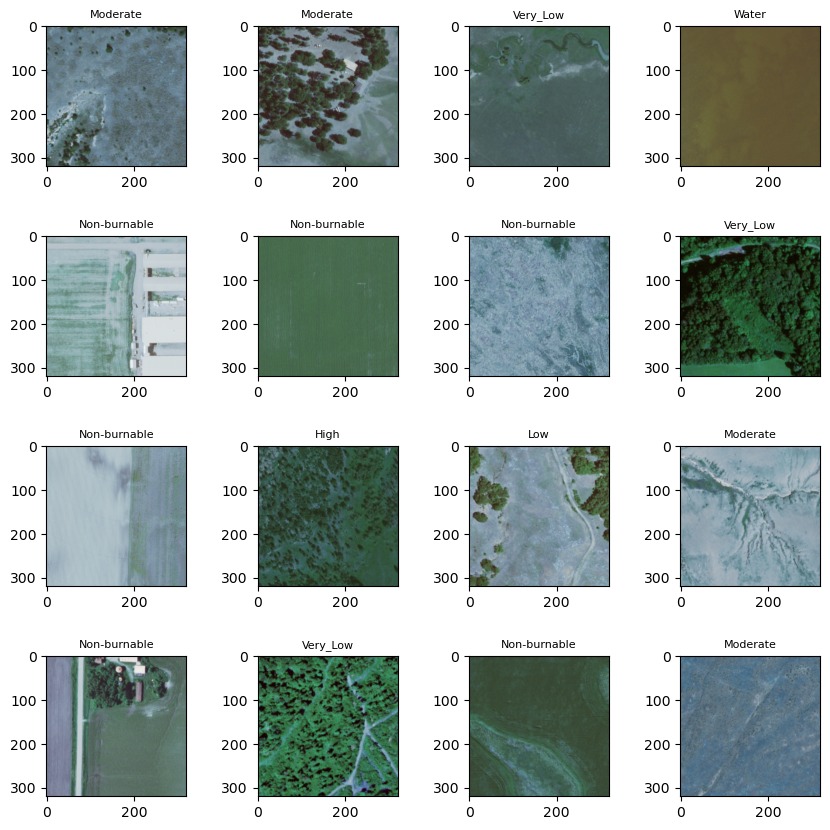

In [9]:
data = pd.read_csv("/kaggle/input/firerisk/FireRisk_Train/metadata.csv")

fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        ix = np.random.choice(data.index.tolist())  # Índice aleatorio
        image_path = "/kaggle/input/firerisk/FireRisk_Train/" + data.iloc[ix].Filename
        label = data.iloc[ix].Label

        # Abrimos la imagen
        img = Image.open(image_path)

        axs[i, j].imshow(img)
        axs[i, j].set_title(label_to_index[label], fontsize=8)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.savefig("DataFireRisk.png")

plt.show()

## Data

In [10]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.folder_base = "/kaggle/input/firerisk/FireRisk_Train/"
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, ix):
        path = self.images[ix] # Path de la imagen
        label = self.labels[ix]
        img = Image.open(self.folder_base + path)
        # Dejamos el canal en la última dimensión
        return transformToTensor(img), torch.tensor(label)

In [11]:
class DataModule(pl.LightningDataModule):
    def __init__(self,
                 batch_size = 64,
                ):
        super().__init__()
        self.batch_size = batch_size
    
    def setup(self, stage=None):
        # Las listas despúes las pasamos al Dataset
        train = train_df
        train_images = train['Filename'].tolist()
        train_labels = train['Label'].tolist()
        self.train_ds = Dataset(train_images, train_labels)
        
        val = valid_df
        val_images = val['Filename'].tolist()
        val_labels = val['Label'].tolist()
        self.val_ds = Dataset(val_images, val_labels)

    def train_dataloader(self, shuffle=True):
        return DataLoader(
            self.train_ds, 
            batch_size = self.batch_size, 
            shuffle = True,
            num_workers = 2,
            persistent_workers=True
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_ds, 
            batch_size = self.batch_size,
            num_workers = 2,
            persistent_workers=True
        )

In [12]:
dm = DataModule()
dm.setup()

images, labels = next(iter(dm.train_dataloader()))
images.shape, labels.shape, images.dtype, labels.dtype
# Checkeamos dimensiones

(torch.Size([64, 3, 54, 54]), torch.Size([64]), torch.float32, torch.int64)

## Model

In [13]:
class Model(pl.LightningModule):
    def __init__(self, n_classes = 7):
        super().__init__()
        self.n_classes = n_classes
        self.resnet = torchvision.models.resnet18()
        self.resnet.load_state_dict(torch.load("/kaggle/input/resnet18/resnet18.pth"))
        # https://download.pytorch.org/models/resnet18-f37072fd.pth
        # Cambiamos última capa de la resnet-18
        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features, n_classes)
        
    def forward(self, x):
        return self.resnet(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = torchmetrics.functional.accuracy(y_hat, y, task='multiclass', num_classes=self.n_classes)
        logs = {'train_loss':loss, 'train_acc':acc}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = torchmetrics.functional.accuracy(y_hat, y, task='multiclass', num_classes=self.n_classes)
        logs = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=3e-4)
        return optimizer

## Training

In [14]:
CONFIG = dict (
    model_name = 'resnet18',
    pretrained = True,
    num_classes = 7,
    lr = 3e-4,
    num_epochs = 100,
    batch_size = 64
)

#es = EarlyStopping(monitor='val_acc', mode='max', patience=3)
# Dejamos de entrenar si la accuracy de la validación no mejora después de 3 logs

checkpoint = ModelCheckpoint(
    filename='/kaggle/working/saves/resnet18-{val_acc:.5f}',
    save_top_k = 1, # Guardamos el modelo con mejor accuracy en la validación
    monitor='val_acc',
    mode='max'
)

wandb_logger = WandbLogger(project='fach-baseline', 
                           config=CONFIG,
                           group='ResNet18', 
                           job_type='train'
                          )

wandb: Currently logged in as: andrewsebad. Use `wandb login --relogin` to force relogin


In [15]:
trainer = pl.Trainer(
    accelerator="auto", 
    devices="auto",
    max_epochs=20,
    log_every_n_steps=10, # Cada 10 batches
    callbacks=[checkpoint],
    logger=wandb_logger
    )

In [16]:
model = Model() # Inicializamos la resnet

In [17]:
trainer.fit(model, dm)
# Guardé los logs en WB

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:540: PossibleUserWarning: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:540: PossibleUserWarning: It is recommended to use `self.log('val_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

[W reducer.cpp:1298] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1298] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:540: PossibleUserWarning: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:540: PossibleUserWarning: It is recommended to use `self.log('train_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  category=PossibleUserWarning,


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [18]:
os.listdir("/kaggle/working/saves")

['resnet18-val_acc=0.51848.ckpt']

In [20]:
checkpoint = "/kaggle/working/saves/resnet18-val_acc=0.51848.ckpt"

state_dict = torch.load(checkpoint, map_location='cpu')['state_dict']
model = Model()
model.load_state_dict(state_dict)

<All keys matched successfully>

In [21]:
model.eval() # Modo evaluación, apagar dropout y batch normalization general

Model(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

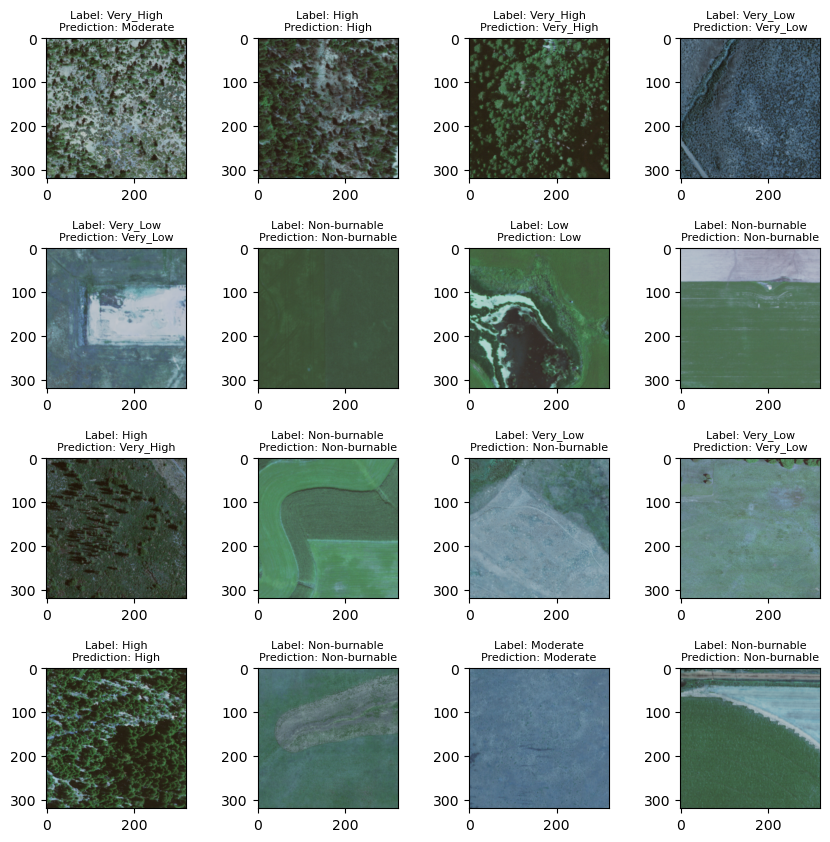

In [22]:
data = pd.read_csv("/kaggle/input/firerisk/FireRisk_Train/metadata.csv")

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i in range(4):
    for j in range(4):
        ix = np.random.choice(data.index.tolist())  # Índice aleatorio
        image_path = "/kaggle/input/firerisk/FireRisk_Train/" + data.iloc[ix].Filename
        label = label_to_index[data.iloc[ix].Label]

        img = Image.open(image_path)
        imagen = img
        axs[i, j].imshow(img)

        img = transformToTensor(img).unsqueeze(0)  # Agregamos dimensión del batch
        y_hat = model(img)
        y_probabilities = F.softmax(y_hat, dim=1)
        predicted_class = torch.argmax(y_probabilities, dim=1).item()
        prediction = label_to_index[predicted_class]

        axs[i, j].set_title('Label: ' + label + '\nPrediction: ' + prediction, fontsize=8)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.savefig("DataFireRiskValidation.png")

plt.show()

## Inferencia con Fasat Charlie

El modelo fue entrenado con imágenes de 270x270 metros. Por lo tanto, tomaremos ventanas de 270/5=54 píxeles, que representan aproximadamente 270x270 metros.

In [36]:
import rasterio
from rasterio.windows import Window
from tqdm import tqdm

def calculate_stride(image_shape, patch_size):
    height, width = image_shape[:2]
    patch_height, patch_width = patch_size
    height_divisors = [i for i in range(1, min(height, patch_height) + 1) if height % i == 0 and patch_height % i == 0]
    width_divisors = [i for i in range(1, min(width, patch_width) + 1) if width % i == 0 and patch_width % i == 0]
    stride = max(height_divisors + width_divisors)
    return stride

def apply_sliding_window(model, image_path, window_size):
    with rasterio.open(image_path) as src:
        raster = src.read()
        width = src.width
        height = src.height
        num_bands = src.count

        # raster original
        profile = src.profile

        # mask
        full_mask = np.full((1, height, width), 255, dtype=np.uint8)
        window_size = calculate_stride([3, height, width], (54, 54))
        print("Stride: " + str(window_size))

        for col_off in tqdm(range(0, width, window_size)):
            for row_off in range(0, height, window_size):
                window = Window(col_off, row_off, 54, 54)
                
                x = src.read(window=window)
                
                if (x.shape[1] != 54) or (x.shape[2] != 54):
                    continue
                    
                if np.isnan(x).any():
                    continue
                
                x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
                x_prev = x
                
                label_prediction = model(x)

                mask = torch.argmax(label_prediction, dim=1).item()

                full_mask[:, row_off:row_off+54, col_off:col_off+54] = mask

    return full_mask, profile, raster

window_size = 54

full_mask, profile, raster = apply_sliding_window(model, '/kaggle/input/valpo-test/valpo_test.tif', window_size)
profile['count'] = 1
profile['nodata'] = 255

Stride: 3


In [30]:
with rasterio.open('/kaggle/working/valpo_prediction.tif', 'w', **profile) as dst:
    dst.write(full_mask)